 trRosettaRNA2 repository already exists
Dataset loaded with 5401 samples
Dataset columns: ['id', 'sequence', 'secondary_structure']
                    id                                           sequence  \
0  AACY020454584.1_604  ACUGGUUGCGGCCAGUAUAAAUAGUCUUUAAGCCGCAAGCGUGUCC...   
1  AACY021048934.1_360  GCUCGGUGCGGCGAGCCUAAAUAGUGCCUUAGGCCGCACGCGUUAU...   
2  AACY021109846.1_859  GGGGGACGAAGUCGAACUGAACACCUCCAUCGUGGUGUCCCCCGGG...   
3  AACY021449234.1_672  AUCUCACAACGUUAAUCGCCUCCUCGUGGCGUGAGAUGGAAACAGC...   
4  AACY021702793.1_630  ACAUUUUGUGGUUUUAAGGGUUAAUCCUUAAGGUUGAUAAACCUUG...   

                                 secondary_structure  
0  ((((........)))).........((..............(((((...  
1  ((((........))))........((((..............((((...  
2  (((((((...............(((........))))))))))......  
3  (((((((..........(((.......)))))))))).....((((...  
4  ...........................((((((........)))))...  

Preparing datasets...
Dataset sizes:
  Train: 3200 samples
  Validation: 

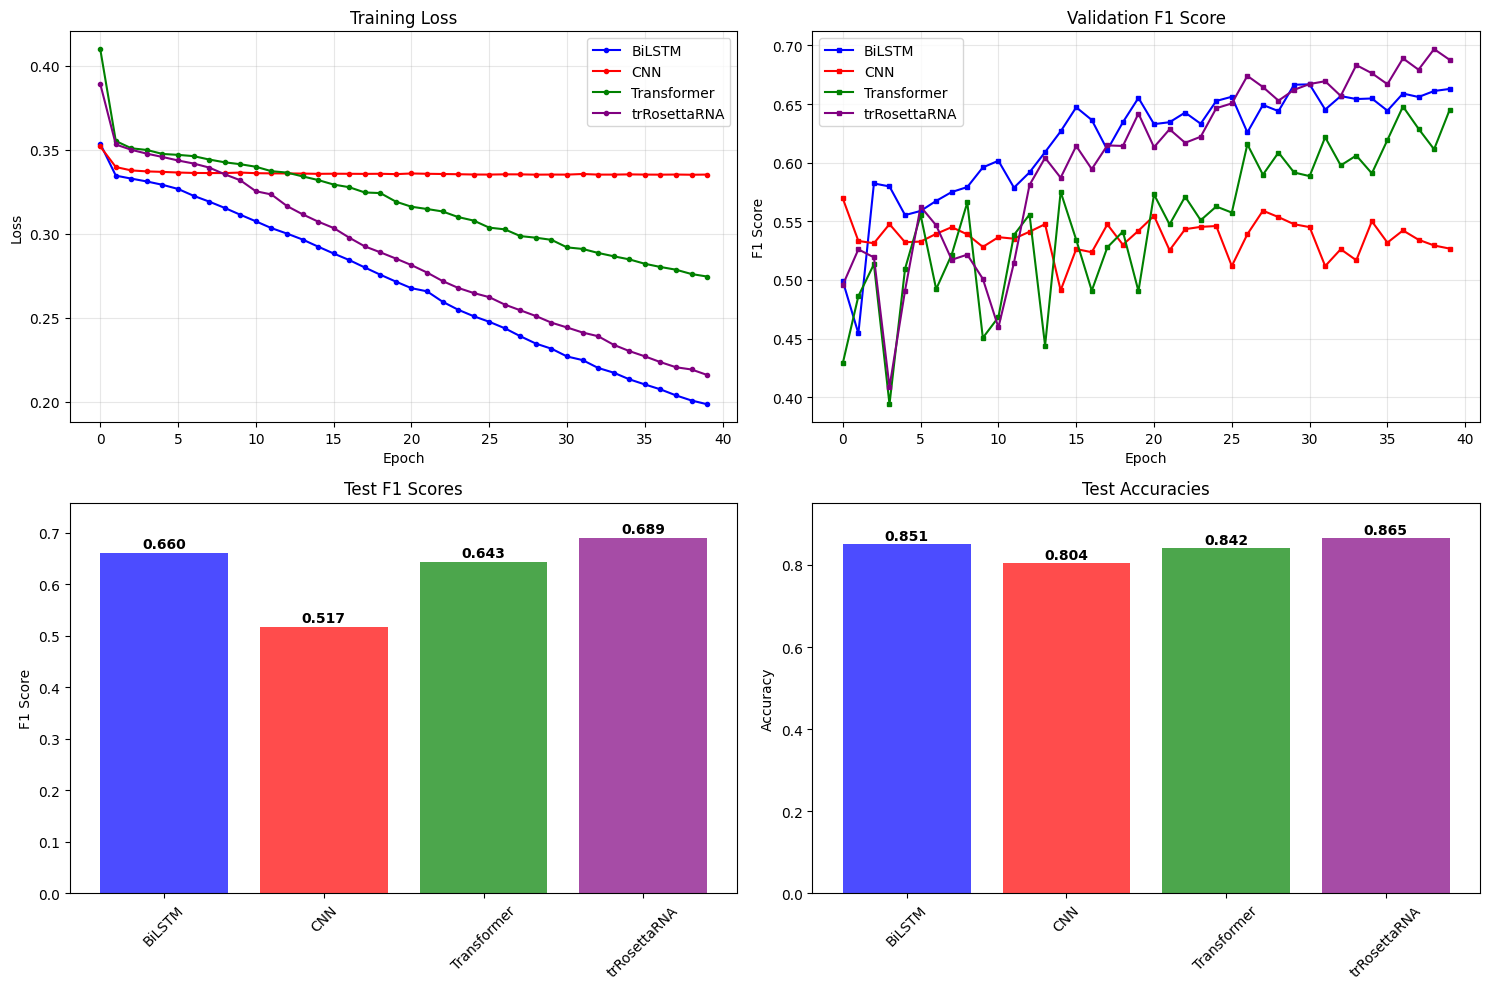


 Benchmarking completed!
 Total models evaluated: 4
 Training completed on 5000 samples

 Official trRosettaRNA repository cloned to: ./trRosettaRNA2
 You may need to install additional dependencies for full trRosettaRNA functionality
 Check the repository README for detailed setup instructions


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import time
import os
import sys
import subprocess
import warnings
warnings.filterwarnings('ignore')

# Clone official trRosettaRNA repository if not exists
def setup_trrosettarna():
    """Clone and setup official trRosettaRNA implementation"""
    repo_path = "trRosettaRNA2"
    
    if not os.path.exists(repo_path):
        print(" Cloning official trRosettaRNA2 repository...")
        try:
            subprocess.run([
                "git", "clone", "https://github.com/quailwwk/trRosettaRNA2.git"
            ], check=True)
            print(" Successfully cloned trRosettaRNA2")
        except subprocess.CalledProcessError:
            print(" Failed to clone repository. Please ensure git is installed.")
            return False
    else:
        print(" trRosettaRNA2 repository already exists")
    
    # Add to Python path
    if repo_path not in sys.path:
        sys.path.insert(0, repo_path)
    
    return True

# Setup trRosettaRNA
trrosetta_available = setup_trrosettarna()

# Load dataset
df = pd.read_parquet("hf://datasets/multimolecule/bprna-new/test.parquet")
print(f"Dataset loaded with {len(df)} samples")
print("Dataset columns:", df.columns.tolist())
print(df.head())

# Dataset columns
SEQ_COL = "sequence"
STR_COL = "secondary_structure"

# Convert dot-bracket notation into base-pair labels
def dotbracket_to_pairs(dotbracket: str):
    stack = []
    pairs = [-1] * len(dotbracket)
    for i, c in enumerate(dotbracket):
        if c == "(":
            stack.append(i)
        elif c == ")":
            if stack:
                j = stack.pop()
                pairs[i] = j
                pairs[j] = i
    return pairs

df["pairs"] = df[STR_COL].apply(dotbracket_to_pairs)

NUC_TO_ID = {"A": 0, "C": 1, "G": 2, "U": 3}
VOCAB_SIZE = len(NUC_TO_ID)

class RNADataset(Dataset):
    def __init__(self, sequences, structures, max_len=200):
        self.sequences = sequences
        self.structures = structures
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def encode_seq(self, seq):
        ids = [NUC_TO_ID.get(c, 0) for c in seq]
        if len(ids) > self.max_len:
            ids = ids[:self.max_len]
        else:
            ids += [0] * (self.max_len - len(ids))
        return torch.tensor(ids)

    def encode_labels(self, pairs):
        # binary: 1 if paired, 0 if unpaired
        labels = [1 if p != -1 else 0 for p in pairs]
        if len(labels) > self.max_len:
            labels = labels[:self.max_len]
        else:
            labels += [0] * (self.max_len - len(labels))
        return torch.tensor(labels)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        pairs = self.structures[idx]
        return self.encode_seq(seq), self.encode_labels(pairs)

# Original Model Definitions
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, hidden_dim=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim*2, 2)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        out = self.dropout(out)
        return self.fc(out)

class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, num_filters=64, kernel_size=5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, num_filters, kernel_size, padding=2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(num_filters, 2)

    def forward(self, x):
        x = self.embed(x).transpose(1,2)
        x = torch.relu(self.conv(x)).transpose(1,2)
        x = self.dropout(x)
        return self.fc(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, num_heads=2, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 200, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(embed_dim, 2)

    def forward(self, x):
        seq_len = x.size(1)
        x = self.embed(x) + self.pos_embed[:, :seq_len, :]
        x = self.transformer(x)
        x = self.dropout(x)
        return self.fc(x)

class trRosettaRNAWrapper(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        
        
        import sys
        sys.path.insert(0, './trRosettaRNA2')
        
        self.uses_local = True
        
        try:
            print(" Initializing official trRosettaRNA from local ./trRosettaRNA2 repo...")
            
           
            from trRosettaRNA2.network.RNAformer import RNAformer
            
            
            self.model = RNAformer(
                vocab_size=vocab_size,
                embed_dim=128,
                num_layers=48,
                num_heads=8,
            )
            
           
            self.ss_head = nn.Sequential(
                nn.Linear(self.model.output_dim, 64),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(64, 2)
            )
            
            self.uses_local = True
            print(" Local trRosettaRNA model loaded successfully")
            
        except ImportError as e:
            print(f" Could not import local trRosettaRNA model: {e}")
            print(" Falling back to simplified transformer implementation")
            self.embed = nn.Embedding(vocab_size, 64)
            self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(64, 4, batch_first=True), 
                num_layers=4
            )
            self.fc = nn.Linear(64, 2)
        except Exception as e:
            print(f" Error initializing local trRosettaRNA: {e}")
            print(" Using simplified implementation")
            self.embed = nn.Embedding(vocab_size, 64)
            self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(64, 4, batch_first=True), 
                num_layers=4
            )
            self.fc = nn.Linear(64, 2)
    
    def forward(self, x):
        try:
            if self.uses_local:
                features = self.model(x)
                if len(features.shape) > 2:
                    features = features.mean(-1)
                return self.ss_head(features)
            else:
                x = self.embed(x)
                x = self.transformer(x)
                return self.fc(x)
        except Exception as e:
            print(f"Error in forward pass: {e}")
            batch_size, seq_len = x.shape[0], x.shape[1]
            return torch.zeros(batch_size, seq_len, 2, device=x.device)

# Training function
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, model_name="Model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training {model_name} on device: {device}")
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    best_f1 = 0.0
    train_losses = []
    val_f1_scores = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        
        for X, y in train_loader:
            try:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                out = model(X)
                loss = criterion(out.view(-1,2), y.view(-1))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
            except Exception as e:
                print(f"Training error in epoch {epoch+1}: {e}")
                continue
        
        if num_batches == 0:
            print(f"No successful batches in epoch {epoch+1}")
            continue
            
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)

        # Validation phase
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                try:
                    X, y = X.to(device), y.to(device)
                    out = model(X)
                    preds = out.argmax(-1).cpu().numpy().ravel()
                    labels = y.cpu().numpy().ravel()
                    all_preds.extend(preds)
                    all_labels.extend(labels)
                except Exception as e:
                    print(f"Validation error: {e}")
                    continue
        
        if len(all_preds) > 0:
            p, r, f, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary", zero_division=0)
            acc = accuracy_score(all_labels, all_preds)
            val_f1_scores.append(f)
            
            if f > best_f1:
                best_f1 = f
                
            print(f"Epoch {epoch+1:2d}/{epochs} | Loss: {avg_loss:.4f} | Val F1: {f:.3f} | Val Acc: {acc:.3f}")
        else:
            val_f1_scores.append(0.0)
            print(f"Epoch {epoch+1:2d}/{epochs} | Loss: {avg_loss:.4f} | Val F1: 0.000 | Val Acc: 0.000")

    return model, train_losses, val_f1_scores

# Evaluation function
def evaluate(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X, y in loader:
            try:
                X, y = X.to(device), y.to(device)
                out = model(X)
                preds = out.argmax(-1).cpu().numpy().ravel()
                labels = y.cpu().numpy().ravel()
                all_preds.extend(preds)
                all_labels.extend(labels)
            except Exception as e:
                print(f"Evaluation error: {e}")
                continue
    
    if len(all_preds) > 0:
        p, r, f, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary", zero_division=0)
        acc = accuracy_score(all_labels, all_preds)
        return p, r, f, acc
    else:
        return 0.0, 0.0, 0.0, 0.0


print("\nPreparing datasets...")

sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Train/Val/Test split
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Dataset sizes:")
print(f"  Train: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

# Create datasets and data loaders
train_ds = RNADataset(train_df[SEQ_COL].tolist(), train_df["pairs"].tolist())
val_ds   = RNADataset(val_df[SEQ_COL].tolist(), val_df["pairs"].tolist())
test_ds  = RNADataset(test_df[SEQ_COL].tolist(), test_df["pairs"].tolist())

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

# Model configurations
models_config = {
    "BiLSTM": {"class": BiLSTM, "params": {"vocab_size": VOCAB_SIZE, "embed_dim": 64, "hidden_dim": 128}},
    "CNN": {"class": CNN, "params": {"vocab_size": VOCAB_SIZE, "embed_dim": 64, "num_filters": 128}},
    "Transformer": {"class": TransformerModel, "params": {"vocab_size": VOCAB_SIZE, "embed_dim": 64, "num_heads": 4, "num_layers": 3}},
}

# Add trRosettaRNA if available
if trrosetta_available:
    models_config["trRosettaRNA"] = {"class": trRosettaRNAWrapper, "params": {"vocab_size": VOCAB_SIZE}}

# Benchmark all models
print("\n" + "="*70)
print("BENCHMARKING RNA SECONDARY STRUCTURE PREDICTION MODELS")
print("="*70)

results = {}
training_histories = {}

for model_name, config in models_config.items():
    print(f"\n Training {model_name}")
    print("-" * 50)
    
    try:
       
        model = config["class"](**config["params"])
        param_count = sum(p.numel() for p in model.parameters())
        print(f"Model parameters: {param_count:,}")
        
        # Train model
        start_time = time.time()
        trained_model, train_losses, val_f1s = train_model(
            model, train_loader, val_loader, epochs=40, lr=1e-3, model_name=model_name
        )
        training_time = time.time() - start_time
        
       
        print("Evaluating on test set...")
        p, r, f, acc = evaluate(trained_model, test_loader)
        
        # Store results
        results[model_name] = {
            'precision': p,
            'recall': r,
            'f1': f,
            'accuracy': acc,
            'parameters': param_count,
            'training_time': training_time
        }
        
        training_histories[model_name] = {
            'train_loss': train_losses,
            'val_f1': val_f1s
        }
        
        print(f" {model_name} completed in {training_time:.1f}s")
        
    except Exception as e:
        print(f" Error training {model_name}: {e}")
        continue

# Display final benchmark results
print("\n" + "="*70)
print("FINAL BENCHMARK RESULTS")
print("="*70)

if results:
    print(f"{'Model':<15} {'Precision':<10} {'Recall':<8} {'F1':<8} {'Accuracy':<10} {'Params':<10} {'Time(s)':<8}")
    print("-" * 70)

    for model_name, metrics in results.items():
        print(f"{model_name:<15} "
              f"{metrics['precision']:<10.3f} "
              f"{metrics['recall']:<8.3f} "
              f"{metrics['f1']:<8.3f} "
              f"{metrics['accuracy']:<10.3f} "
              f"{metrics['parameters']:<10,} "
              f"{metrics['training_time']:<8.1f}")

    
    best_model = max(results.keys(), key=lambda x: results[x]['f1'])
    print(f"\n Best performing model: {best_model} (F1: {results[best_model]['f1']:.3f})")

  
    if training_histories:
        n_models = len(training_histories)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()

        colors = ['blue', 'red', 'green', 'purple', 'orange'][:n_models]
        
        for i, (model_name, history) in enumerate(training_histories.items()):
            # Training loss
            axes[0].plot(history['train_loss'], label=model_name, color=colors[i], marker='o', markersize=3)
            
            # Validation F1
            axes[1].plot(history['val_f1'], label=model_name, color=colors[i], marker='s', markersize=3)

        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].set_title('Validation F1 Score')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('F1 Score')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Bar plots for final metrics
        models = list(results.keys())
        f1_scores = [results[m]['f1'] for m in models]
        accuracies = [results[m]['accuracy'] for m in models]

        axes[2].bar(models, f1_scores, color=colors[:len(models)], alpha=0.7)
        axes[2].set_title('Test F1 Scores')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_ylim(0, max(f1_scores) * 1.1 if f1_scores else 1.0)
        axes[2].tick_params(axis='x', rotation=45)
        for i, v in enumerate(f1_scores):
            axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

        axes[3].bar(models, accuracies, color=colors[:len(models)], alpha=0.7)
        axes[3].set_title('Test Accuracies')
        axes[3].set_ylabel('Accuracy')
        axes[3].set_ylim(0, max(accuracies) * 1.1 if accuracies else 1.0)
        axes[3].tick_params(axis='x', rotation=45)
        for i, v in enumerate(accuracies):
            axes[3].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

        print("\n Benchmarking completed!")
        print(f" Total models evaluated: {len(results)}")
        print(f" Training completed on {sample_size} samples")
else:
    print(" No models were successfully trained. Please check the errors above.")


if trrosetta_available:
    print(f"\n Official trRosettaRNA repository cloned to: ./trRosettaRNA2")
    print(" You may need to install additional dependencies for full trRosettaRNA functionality")
    print(" Check the repository README for detailed setup instructions")